In this tutorial we will explore the SklearnNode. The sklearn node is a readout node similar to the 
native ridge node, suitable for offline learning. However, it incorporates a host of Sklearn's liner estimators
suitable for various classification and regression tasks. 

Currently we support Linear classifiers like LogisticRegression, Perceptron, 
RidgeClassifier and Linear regressors like Ridge, LinearRegression
Lasso and ElasticNet.

For more information on the above mentioned estimators, please visit sklearn linear model [API reference](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)


### SklearnNode usage

In [1]:
import sys
sys.path.insert(0, '../')
import reservoirpy as rpy
from reservoirpy.nodes import SklearnNode
rpy.verbosity(0)

readout = SklearnNode(method="Ridge", alpha=1e-3)

The hyper parameters can be selected by looking at the documentation of each method.

Let's try the classic sinewave forecasting task from the tutorial 1. 

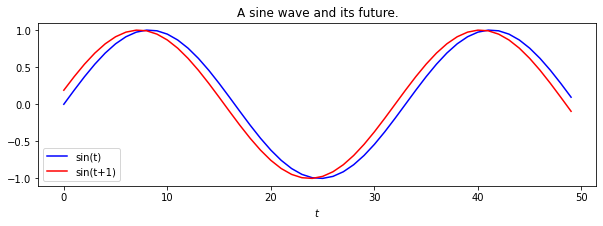

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = np.sin(np.linspace(0, 6*np.pi, 100)).reshape(-1, 1)
X_train = X[:50]
y_train = X[1:51]
X_test, y_test = X[50:len(X)-1], X[51:len(X)] 
plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(X_train, label="sin(t)", color="blue")
plt.plot(y_train, label="sin(t+1)", color="red")
plt.legend()
plt.show()

Let's create a reservoir node and add our sklearn ridge method to it. This will give
us the ESN model.

(50, 1)
(50, 1)


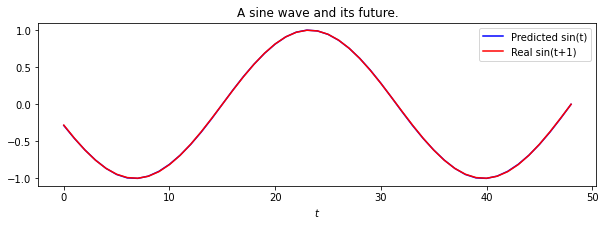

In [3]:
from reservoirpy.nodes import Input, Reservoir

reservoir = Reservoir(100, lr=0.5, sr=0.9)
esn_model = reservoir >> readout
print(X_train.shape)
print(y_train.shape)
res = esn_model.fit(X_train, y_train)
y_pred = esn_model.run(X_test)
plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(y_pred, label="Predicted sin(t)", color="blue")
plt.plot(y_test, label="Real sin(t+1)", color="red")
plt.legend()
plt.show()

Pretty Awesome right? Now we can import different regression models from sklearn library and use it to forecast or predict from time-series data. :)

Let's try other linear estimators like Lasso or ElasticNet. But predcicting since wave can be bore. Let's use the Mackey Glass time-series data from reservoirpy.   

In [4]:
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 2510
tau = 17
X = mackey_glass(timesteps, tau=tau)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

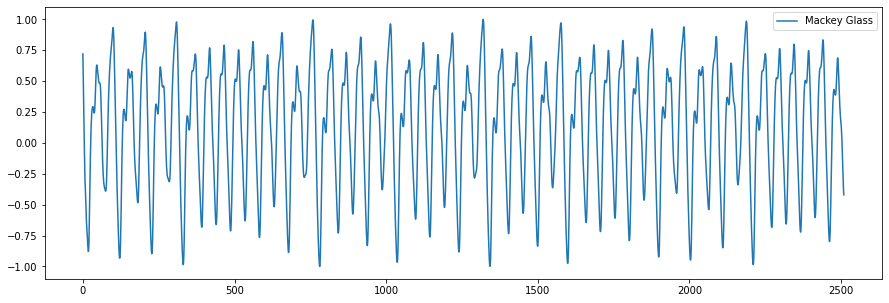

In [5]:
def plot_mackey(X):
    sample = 500
    test_len = X.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(X, label="Mackey Glass")
    plt.legend()
    plt.show()
plot_mackey(X)

### Build Echo State Network

In [6]:
def build_esn(method=None, alpha=None):
    units = 100
    leak_rate = 0.3
    spectral_radius = 1.25
    input_scaling = 1.0
    connectivity = 0.1
    input_connectivity = 0.2
    regularization = 1e-8
    seed = 1234
    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    if method == "LinearRegression":
        readout   = SklearnNode(method=method)
    else:
        readout = SklearnNode(method=method, alpha=alpha)
    esn = reservoir >> readout
    return esn

In [7]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [8]:
from reservoirpy.datasets import to_forecasting
from reservoirpy.utils.sklearn_helper import TransformInputSklearn, TransformOutputSklearn
x, y = to_forecasting(X, forecast=100)
encoder = TransformInputSklearn()
x, y = encoder(x,y, task="regression")
X_train, y_train = x[:2000], y[:2000]
X_test, y_test = x[2000:], y[2000:]

In [9]:
esn = build_esn(method="Ridge", alpha=1e-7)
res = esn.fit(X_train, y_train)
y_pred = esn.run(X_test)

In [10]:
y_pred = np.array(y_pred)
y_pred, y_test = y_pred.squeeze(), y_test.squeeze()

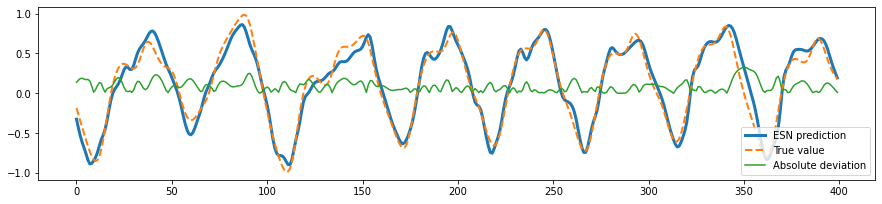

In [11]:
plot_results(y_pred, y_test, sample=400)

In [12]:
r2_esn, nr_esn  = rsquare(y_test, y_pred), nrmse(y_test, y_pred)

### Let's compare other sklearn estimators with Ridge

As you will remember, we have support for LinearRegresion, Ridge, Lasso and ElasticNet. So it 
would a good idea to compare the other three regression model performances with Ridge. Let us create 
three other readouts. For information regarding the various hyper-parameters, we request you to take
a look at their respective documentation proveded by the sklearn library. So without much further delay
let's get into it.

Each separate readout will be attached to the original reservoir, which will in turn give us three separate 
esn models. Let us first create create and train an esn model using Sklearn's Linear regession method and then
generate predicition using it on the X_test.

In [13]:
esn2 = build_esn(method="LinearRegression")
y_pred2 = np.array(esn2.fit(X_train, y_train).run(X_test)).squeeze()
r2_esn2, nr_esn2  = rsquare(y_test, y_pred2), nrmse(y_test, y_pred2)

Now, let's repeat the same set of experiments for Lasso and ElasticNet and find their
R square and normalized root mean square error metrics.

In [14]:
esn3 = build_esn(method="Lasso", alpha=1e-6)
y_pred3 = np.array(esn3.fit(X_train, y_train).run(X_test)).squeeze()
r2_esn3, nr_esn3  = rsquare(y_test, y_pred3), nrmse(y_test, y_pred3)

/Users/deep/opt/miniconda3/envs/pytorch2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.5951852693516, tolerance: 0.04818157045450285
  model = cd_fast.enet_coordinate_descent(


In [15]:
esn4 = build_esn(method="ElasticNet", alpha=1e-8)
y_pred4 = np.array(esn4.fit(X_train, y_train).run(X_test)).squeeze()
r2_esn4, nr_esn4  = rsquare(y_test, y_pred4), nrmse(y_test, y_pred4)

/Users/deep/opt/miniconda3/envs/pytorch2/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.17140820721569, tolerance: 0.04818157045450285
  model = cd_fast.enet_coordinate_descent(


Now let us plot the R2 and nrmse metrics.

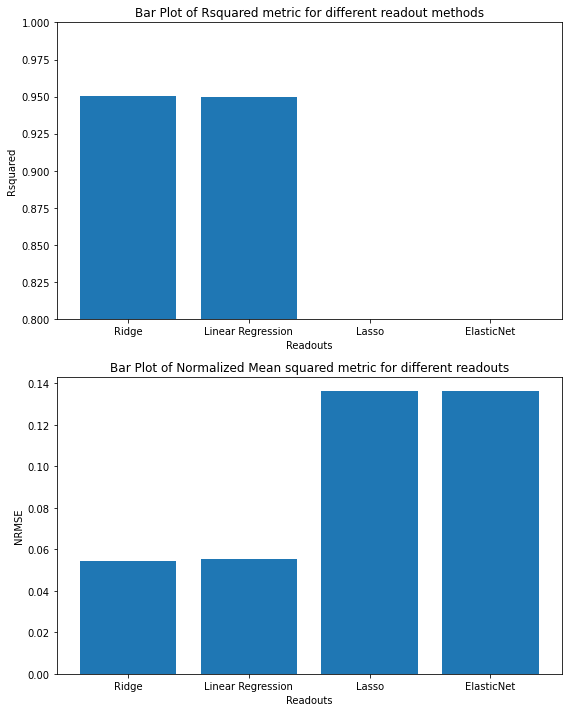

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
list1 = [r2_esn, r2_esn2, r2_esn3, r2_esn4]
list2 = [nr_esn, nr_esn2, nr_esn3, nr_esn4]

# Labels for the bars
labels = ['Ridge', 'Linear Regression', 'Lasso', 'ElasticNet']

# Create a subplot with 2 rows and 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot the first bar chart
axes[0].bar(labels, list1)
axes[0].set_title('Bar Plot of Rsquared metric for different readout methods')
axes[0].set_xlabel('Readouts')
axes[0].set_ylabel('Rsquared')
axes[0].set_ylim([.8, 1.])
# Plot the second bar chart
axes[1].bar(labels, list2)
axes[1].set_title('Bar Plot of Normalized Mean squared metric for different readouts')
axes[1].set_xlabel('Readouts')
axes[1].set_ylabel('NRMSE')

# Adjust the layout
fig.tight_layout()

# Show the plots
plt.show()


You will notice that Lasso and ElasticNet models performing below par compared to the Linear Regression and Ridge method. You will also, notice from their hyper parameters, both take several magnitudes of iterations more that Ridge and Linear regression readout methods to reach their present performances. Why is that? Well in short Lasso makes a large number of it's coefficients close to zero which in many cases affects the perfromance and since Elastic net is a combination of Ridge and Lasso, the Lasso part brings the performance down. Therefore you will notice that although the R2 metric is lower than Ridge yet it is better than tiny bit better than Lasso.

## Chapter 2 : Classification with SklearnNode

We know that the ESN model can perform classification task. We already covered that in Tutorial 6. However, the way we did it was by using the ridge regression method. Although, it perfroms pretty well, regression methods were's designed for classification tasks. Fundamentally, classification is about predicting a label and regression is about predicting a quantity for example the amount of rainfall or sunligh intensity. However, regression models can also predict probabilities. A probability-predicting regression model can be used as part of a classifier by imposing a decision rule for example if the the function returns a value greater than a certain threshold, it belongs to a particular class. However, the problem with Regression models is that they are very sensitive to outlier data and and will thus try to incorporate the outlier in sucha a way that it might affect the decision boundry. You can find a more thorough explanantion on this [link](https://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression)

To perfrom classification on time series data, we will make use of various linrer classifiers from sklearn.
Namely, we have added support for <br /> RidgeClassifier, LogisticRegression, SGDClassifier and Perceptron. For the sake of these tutorial we will show how you can classify a time series <br />data using LogisticRegression, but you can use all the aforementioned methods in an identicle way.

### Creating a toy time-series data for binary classification

The below function will generate sine waves and cosine waves alernatively and label them as 0 and 1. 

In [17]:
import numpy as np

# Function to generate synthetic time series data for classification
def generate_time_series_classification_data(num_samples, num_time_steps, noise_factor=0.1):
    X = np.zeros((num_samples, num_time_steps, 1))
    y = np.zeros(num_samples)

    for i in range(num_samples):
        if i % 2 == 0:
            X[i, :, 0] = np.sin(np.linspace(0, 6 * np.pi, num_time_steps)) + noise_factor * np.random.randn(num_time_steps)
            y[i] = 0
        else:
            X[i, :, 0] = np.cos(np.linspace(0, 6 * np.pi, num_time_steps)) + noise_factor * np.random.randn(num_time_steps)
            y[i] = 1

    return X, y

# Generate the dataset
num_samples = 1000
num_time_steps = 100
X, y = generate_time_series_classification_data(num_samples, num_time_steps)
enocoder = TransformInputSklearn()
X, y = enocoder(X, y, task="classification")

Since the labels have an alternating pattern, it would be a good idea to shuffle and split them into train and test. Also, since reservoir.py expects it's input to in a specific format and classification data might not be in that expected format, we will import an additional function called `check_sklearn_dim` which will ensure that the classification data and labels are in the reservoir py format.

In [18]:
indices = np.arange(num_samples)
np.random.shuffle(indices)
X, y = X[indices], y[indices]
train_split = int(0.8*num_samples)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

Now, let's create an ESN model using sklearn's LogistRegression as a readout node.

In [19]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
seed = 1234
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = SklearnNode(method="LogisticRegression")

esn = reservoir >> readout

In [20]:
from reservoirpy.utils.sklearn_helper import TransformInputSklearn, TransformOutputSklearn
res = esn.fit(X_train, y_train)
y_pred = esn.run(X_test)

In [21]:
decoder = TransformOutputSklearn()
(y_pred, y_test) = decoder(y_pred, y_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred)*100)

100.0
